In [1]:
import pandas as pd
import numpy as np
import os
import csv
import gzip
import sys
import datetime
import ast
import matplotlib.pyplot as plt

In [2]:
score_path = '../results/scores/'
df_scores = pd.read_csv(score_path+'1_3_dat_unique_item.csv')
df_td = df_scores.drop_duplicates(subset='ResponseId', keep='first')
df_agency = pd.read_csv(score_path+'agency_scores.csv')
df_gainloss = pd.read_csv(score_path+'dat_lossgain_scores.csv')
# df_td = pd.read_csv(score_path+'td_scores.csv')
print(len(df_td), len(df_agency), len(df_gainloss)) ## align with R results
### use inner join to merge the dataframes

1349 1344 1348


In [3]:
df_td.columns[0] ### the key to join scores

'ResponseId'

In [4]:
# Add up all columns ending with '_avail' and '_realistic', ignoring NA
avail_sum = df_agency.filter(like='_avail').sum(axis=1, skipna=True)
realistic_sum = df_agency.filter(like='_realistic').sum(axis=1, skipna=True)

# Adding the sums as new columns to the dataframe
df_agency['total_avail'] = avail_sum
df_agency['total_realistic'] = realistic_sum
df_agency['num_items'] = df_agency.apply(lambda row: row[1:19].notna().sum(), axis=1)

In [5]:
df_agency['num_items'].unique()

array([16, 14, 18])

In [6]:
print('item=14', sum(df_agency['num_items'] == 14))
print('item=16', sum(df_agency['num_items'] == 16))
print('item=18', sum(df_agency['num_items'] == 18))
#### most of them answered 16 items and then we used 16 items for rescaling
df_agency['rescale_avail'] = df_agency['total_avail'] / (df_agency['num_items'] / 2) * 8
df_agency['rescale_realistic'] = df_agency['total_realistic'] / (df_agency['num_items'] / 2) * 8
df_agency['agency'] = df_agency['rescale_avail'] + df_agency['rescale_realistic']

item=14 392
item=16 733
item=18 219


In [7]:
df_td_select = df_td[['ResponseId', 'zipcode', 'alloc_debt', 'alloc_spend', 'alloc_save',
       'alloc_invest', 'Age', 'Risk_preference', 'score', 'presbias',
       'absolmag', 'gainloss']]
df_scores = pd.merge(df_td_select,df_gainloss,on='ResponseId',how='inner')
# df_agency_selected = df_agency[['ResponseId', 'total_avail',
#        'total_realistic', 'num_items', 'rescale_avail', 'rescale_realistic','agency',]]
df_agency_selected = df_agency[['ResponseId', 'total_avail',
       'total_realistic', 'num_items', 'rescale_avail', 'rescale_realistic','agency','agency_pub_trans_avail', 'agency_pub_trans_realistic',
       'agency_uber_avail', 'agency_uber_realistic', 'agency_delivery_avail',
       'agency_delivery_realistic', 'agency_grocery_avail',
       'agency_grocery_realistic', 'agency_pharma_avail',
       'agency_pharma_realistic', 'agency_docs_avail', 'agency_docs_realistic',
       'agency_online_avail', 'agency_online_realistic',
       'agency_IP_safe_avail', 'agency_IP_safe_realistic',
       'agency_remote_avail']]
df_merged_scores = df_scores.merge(df_agency_selected,on='ResponseId',how='inner')

In [8]:
def scale_to_100(x, min_val, max_val):
    """
    Scale a given value x from its original range [min_val, max_val] to [0, 100].
    
    Parameters:
    - x: The value to scale.
    - min_val: The minimum value of the original range.
    - max_val: The maximum value of the original range.
    
    Returns:
    - The scaled value in the range [0, 100].
    """
    return (x - min_val) * 100 / (max_val - min_val)

In [9]:
### this depends on the number of items in each type of socres
min_agency, max_agency = -32, 32  
min_td, max_td = 0, 16   
min_loss, max_loss = 0, 6 

In [10]:
regulated_agency = scale_to_100(df_merged_scores['agency'], min_agency, max_agency)
regulated_scores = scale_to_100(df_merged_scores['score'], min_td, max_td)
regulated_loss = scale_to_100(df_merged_scores['loss_aversion_scores'], min_loss, max_loss) 

In [11]:
df_merged_scores['regulated_agency'] = regulated_agency
df_merged_scores['regulated_tdscores'] = regulated_scores
df_merged_scores['regulated_loss'] = regulated_loss

### Zscores

In [12]:
from scipy.stats import zscore
df_merged_scores['agency_z'] = zscore(df_merged_scores['agency'])
df_merged_scores['scores_z'] = zscore(df_merged_scores['score'])
df_merged_scores['loss_z'] = zscore(df_merged_scores['loss_aversion_scores'])

(array([ 19.,   0.,   0.,  49.,   0.,   0., 149.,   0.,   0.,   0., 452.,
          0.,   0., 299.,   0.,   0., 232.,   0.,   0., 144.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ]),
 <BarContainer object of 20 artists>)

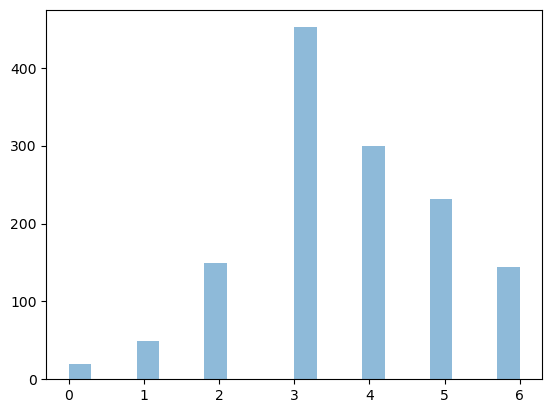

In [13]:

plt.hist(df_merged_scores['loss_aversion_scores'], bins=20, alpha=0.5, label='agency')

(array([ 19.,   0.,   0.,  49.,   0.,   0., 149.,   0.,   0.,   0., 452.,
          0.,   0., 299.,   0.,   0., 232.,   0.,   0., 144.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

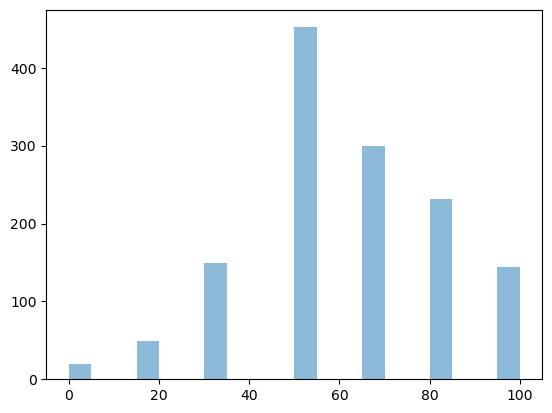

In [14]:
plt.hist(df_merged_scores['regulated_loss'], bins=20, alpha=0.5, label='agency')

(array([ 19.,   0.,   0.,  49.,   0.,   0., 149.,   0.,   0., 452.,   0.,
          0.,   0., 299.,   0.,   0., 232.,   0.,   0., 144.]),
 array([-2.71391711, -2.49164382, -2.26937054, -2.04709725, -1.82482397,
        -1.60255069, -1.3802774 , -1.15800412, -0.93573083, -0.71345755,
        -0.49118427, -0.26891098, -0.0466377 ,  0.17563559,  0.39790887,
         0.62018215,  0.84245544,  1.06472872,  1.28700201,  1.50927529,
         1.73154857]),
 <BarContainer object of 20 artists>)

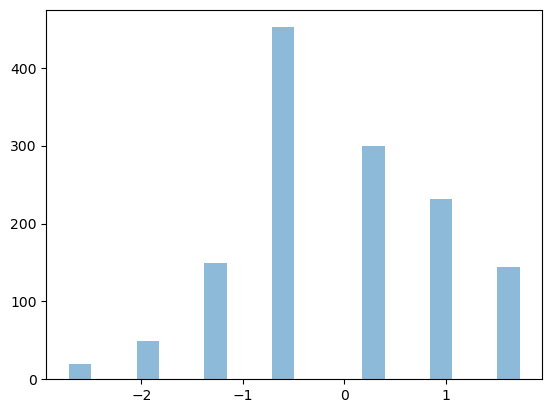

In [15]:
plt.hist(df_merged_scores['loss_z'], bins=20, alpha=0.5, label='agency')

### aggrated to modzcta level

In [16]:
zip_modzcta = pd.read_csv('../results/counts/modzcta_zip_counts.csv')

In [17]:
df_merged_scores['zipcode'] = df_merged_scores['zipcode'].astype(str)
df_merged_scores['zipcode_5'] = df_merged_scores['zipcode'].str.slice(0, 5).astype(int)

In [18]:
df_merged_scores_mod = df_merged_scores.merge(zip_modzcta, left_on='zipcode_5', right_on='zip_code', how='left')

In [19]:
selected_columns = ['score', 'gain_bias', 'loss_bias', 
                    'loss_aversion_scores', 'rescale_avail', 'rescale_realistic','agency',
                    'regulated_tdscores','regulated_agency','regulated_loss']
aggregations = {col: ['mean', 'median', 'std'] for col in selected_columns}
df_aggregated = df_merged_scores_mod.groupby('MODZCTA').agg(aggregations)
df_aggregated.reset_index(inplace=True)
df_aggregated.columns = ['_'.join(col).strip() for col in df_aggregated.columns.values]
df_aggregated.rename(columns={'MODZCTA_':'MODZCTA'},inplace=True)

In [20]:
df_aggregated.to_csv(score_path+'modzcta_scores.csv',index=False)

## plot the correlations

In [ ]:
selected_columns_small = [ 'regulated_tdscores','regulated_agency','regulated_loss']
from matplotlib import colors

corr = df_merged_scores[selected_columns_small].corr()
fig, ax = plt.subplots(figsize=(15, 15))  # Optional: specifies the figure size
norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

cax = ax.matshow(corr, cmap='coolwarm',norm=norm)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

# Add a color bar
fig.colorbar(cax)

# Optional: Add annotations with the correlation values
for (i, j), val in np.ndenumerate(corr):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')

plt.title("Correlation Matrix Heatmap", pad=20)
plt.show()

### add other columns of the survey
*not in use for now*

In [ ]:
### can be used in the future
df_survey = pd.read_csv('person_info.csv')

In [ ]:
df_survey_select = df_survey[['ResponseId','expectation_num',
 'internet_num',
 'financial_2020_num',
 'financial_now_num',
 'financial_change_num',
 'credit_debt_num',
 'gender_num',
 'education_num',
 'employment_num',
 'race_num','destination']]

In [ ]:
df_all_survey_num = df_merged_scores.merge(df_survey_select,on='ResponseId',how='left')

In [ ]:
df_all_survey_num.to_csv('survey_scores_perinfo_v2.csv')
# df_all_survey_num.to_csv('survey_scores_perinfo.csv')

In [ ]:
df_all_survey_num

In [ ]:
# df = pd.read_csv('survey_scores_perinfo.csv')
df = pd.read_csv('survey_scores_perinfo_v2.csv')

In [ ]:
plt.hist(df['score'], bins=20, alpha=0.5, label='score')

### check the correlations
*not in use for now*

In [ ]:
# Assuming 'selected_columns' is your DataFrame with selected columns
correlation_matrix = df_all_survey_num[['alloc_debt', 'alloc_spend', 'alloc_save',
       'alloc_invest', 'Age', 'Risk_preference', 'score', 'presbias',
       'absolmag', 'gainloss', 'mask_march2020_num_avg', 'mask_spring2020_num_avg',
       'mask_summer2020_num_avg', 'mask_fall2020_num_avg',
       'mask_winter2020_num_avg', 'indoor_march2020_num_avg',
       'indoor_spring2020_num_avg', 'indoor_summer2020_num_avg',
       'indoor_fall2020_num_avg', 'indoor_winter2020_num_avg',
        'loss_aversion_scores', 'rescale_avail', 'rescale_realistic',
          'expectation_num', 'internet_num',
       'financial_2020_num',  'financial_change_num',
       'credit_debt_num', 'gender_num', 'education_num', 'employment_num',
       'race_num']].corr()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:

plt.figure(figsize=(15, 20),dpi=450)  # Adjust the figure size as needed
cax = plt.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Highlight cells with absolute value greater than 0.5
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > 0.2:
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='yellow', lw=1))

plt.colorbar(cax)

# Adding axis labels with column names for clarity
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90,size=6)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns,size=6)

# Optional: Add a title
# plt.title('Correlation Matrix Heatmap', y=1.15)

# plt.tight_layout()  # Adjust layout to prevent clipping of labels
# plt.show(dpi=450)
plt.savefig('individual_correlation.jpg',dpi=400,bbox_inches='tight')

### check asymmetric of agency scores
*not in use for now*

In [ ]:
df_zipcodes_counts = pd.DataFrame(df_merged_scores.groupby('zipcode')['zipcode'].count())
df_zipcodes_counts.rename(columns={'zipcode':'counts'},inplace=True)
condition = (df_merged_scores['agency_uber_avail'] > df_merged_scores['agency_uber_realistic']) | (df_merged_scores['agency_delivery_avail'] > df_merged_scores['agency_delivery_realistic'])
filtered_df = df_merged_scores[condition]
df_zipcodes_counts['avail_gr_real'] = filtered_df.groupby('zipcode')['zipcode'].count()
condition = (df_merged_scores['agency_uber_avail'] != df_merged_scores['agency_uber_realistic']) | (df_merged_scores['agency_delivery_avail'] != df_merged_scores['agency_delivery_realistic'])
filtered_df = df_merged_scores[condition]
df_zipcodes_counts['avail_nq_real'] = filtered_df.groupby('zipcode')['zipcode'].count()

In [ ]:
df_zipcodes_counts['avail_gr_per'] = df_zipcodes_counts['avail_gr_real']/df_zipcodes_counts['counts']

In [ ]:
df_zipcodes_counts.to_csv('asymmetric_agency_zipcodes.csv')
df_merged_scores.to_csv('actions_scores_indiviudal.csv',index=False)

### unpivot to individual level
*not in use for now*

In [ ]:
selected_columns = ['Age', 'Risk_preference', 'score', 'gain_bias', 'loss_bias', 
                    'loss_aversion_scores', 'rescale_avail', 'rescale_realistic','agency','alloc_debt', 'alloc_spend', 'alloc_save',
       'alloc_invest', 'mask_march2020_num_avg',
       'mask_spring2020_num_avg', 'mask_summer2020_num_avg', 'mask_fall2020_num_avg',
       'mask_winter2020_num_avg', 'indoor_march2020_num_avg', 'indoor_spring2020_num_avg',
       'indoor_summer2020_num_avg', 'indoor_fall2020_num_avg', 'indoor_winter2020_num_avg','zipcode']

In [ ]:
mask_cols = ['mask_march2020_num_avg',
       'mask_spring2020_num_avg', 'mask_summer2020_num_avg', 'mask_fall2020_num_avg',
       'mask_winter2020_num_avg']
melted_df_mask = pd.melt(df_merged_scores, id_vars=['Age',
       'Risk_preference', 'score', 'gain_bias', 'loss_bias', 'rescale_avail',
       'rescale_realistic'], value_vars = mask_cols, 
                    var_name ='period', value_name ='behaviour_mask')
# Correctly adjust the code to perform the intended replacement
# melted_df_mask['week'] = melted_df['week'].apply(lambda x: (int(x.split('_')[1]) - 3))